# INM702 Coursework - Task 1

Group: PG 13

Riyaad Mangera - 230056175

In [1]:
from keras import datasets
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
from numpy.random import default_rng as rng
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from datetime import datetime

## Set the random seed

In [2]:
# Fixes the random seed to ensure all results are somewhat consistent
rng = np.random.RandomState(0)

## Load Dataset

In [3]:
# Load the dataset and split into train, test and validation sets
def load_dataset():

    data = datasets.mnist.load_data()

    (X_train, y_train), (X_test, y_test) = data
    
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.2, random_state = 0)
    
    # Standardise X inputs
    X_train = X_train / 255
    X_test = X_test / 255
    X_valid = X_valid / 255

    # One hot encode y outputs
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    y_valid = to_categorical(y_valid)

    # Flatten and scale X inputs
    X_train = np.reshape(X_train, [X_train.shape[0], 28 * 28])
    X_test = np.reshape(X_test, [X_test.shape[0], 28 * 28])
    X_valid = np.reshape(X_valid, [X_valid.shape[0], 28 * 28])

    X_train = StandardScaler().fit_transform(X_train)
    X_test = StandardScaler().fit_transform(X_test)
    X_valid = StandardScaler().fit_transform(X_valid)
    
    print(X_train[0])
    print(y_test)

    print(X_valid.shape)
    
    return X_train, X_test, y_train, y_test, X_valid, y_valid

In [4]:
X_train, X_test, y_train, y_test, X_valid, y_valid = load_dataset()

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.56440219e-03 -4.56440219e-03 -4.56440219e-03 -4.56440219e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -4.56440219e-03 -5.26560617e-03 -9.83806357e-03 -1.28208593e-02
 -1.52823109e-02 -1.95020891e-02 -2.52071858e-02 -2.83985365e-02
 -2.95919872e-02 -3.02927615e-02 -3.20027390e-02 -3.05751788e-02
 -3.34009966e-02 -3.00731114e-02 -2.40009105e-02 -1.93591109e-02
 -1.59407336e-02 -1.06679678e-02 -7.77093042e-03 -4.56440219e-03
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -4.56440219e-03
 -8.34497013e-03 -1.27302

## Relu Layer

In [5]:
# Contains the forward and backward pass functions for the ReLU layers
class Activation_Layer_ReLU:
    
    # Applies the ReLU function on a given input x
    def forward_pass(self, x):
        
        self.x = x
        
        return np.maximum(0, x)
    
    # Applies the derivative ReLU function on the given input x from the forward pass
    def backward_pass(self, gradients):
        
        return (np.greater(self.x, 0).astype(int)) * gradients
        

## Sigmoid Layer

In [6]:
# Contains the forward and backward pass functions for the Sigmoid layers
class Activation_Layer_Sigmoid:
    
    # Applies the Sigmoid function on a given input x
    def forward_pass(self, x):
        
        self.sigmoid = 1 / (1 + np.exp(-x))
        
        return self.sigmoid
    
    # Applies the derivative Sigmoid function using the sigmoid values calculated in the forward pass
    def backward_pass(self, gradients):
        
        return (self.sigmoid * (1 - self.sigmoid)) * gradients


## Softmax Layer

In [7]:
# Contains the forward and backward pass functions for the Softmax layers
# Backward pass function is currently unused
class Activation_Layer_Softmax:
    
    # Applies the Softmax function on a given input x
    def forward_pass(self, x):
        
        exponents = np.exp(x - np.max(x, axis = 1, keepdims = True))
        
        self.softmax_out = exponents / np.sum(exponents, axis = 1, keepdims = True)
        
        return self.softmax_out
    
    # Applies the derivative Softmax function using the softmax values calculated in the forward pass
    # This function is currently unused, as the derivative of the softmax function is not needed due to the use of
    # the derivative of the Cross Entropy Loss function
    # This function's calculations were developed by Kinsley and Kukieła (2020)
    def backward_pass(self, gradients):
        
        # Create empty array same size as input gradients
        self.dinputs = np.empty_like(gradients)
        
        for idx, (single_output, single_gradient) in enumerate(zip(self.softmax_out, gradients)):
            
            # Flatten output
            single_output = single_output.reshape(-1, 1)
            
            # Create a jacobian matrix for each output
            jacobian_matrix = np.diagflat(single_output) - np.dot(single_output, single_output.T) 
            
            # Calculate sample-wise gradients
            self.new_gradients[idx] = np.dot(jacobian_matrix, single_gradient)
        
        return self.new_gradients * gradients


## Dense Layer

In [8]:
# Contains the initialisation of weights and biases, and forward and backward pass functions for the Dense Layers
# This class also performs L1 and L2 Regularisation during the backward pass
class Layer_Dense:
    
    def __init__(self, n_inputs, n_neurons, l2_lambda = 1e-5):
        
        self.weights = (rng.randn(n_inputs, n_neurons) * np.sqrt(2/n_neurons)) #He Initialisation
        self.biases = 0.01 * (rng.randn(1, n_neurons))
        
        self.l2_lambda = l2_lambda
    
    # Applies the standard Linear function on a given input x
    def forward_pass(self, x):
        
        self.x = x
        
        return np.dot(x, self.weights) + self.biases
    
    # Computes gradients for the layer's weights and biases and performs L1 and L2 regularisation
    def backward_pass(self, gradients):
        
        N = len(self.x)
        
        self.dweights = np.dot(self.x.T, gradients)
        self.dbiases = np.sum(gradients, axis = 0, keepdims = True)
        
        # Run L2 Regularisation on the layer's weights and biases
        self.dweights += 2 * self.l2_lambda * self.weights
        self.dbiases += 2 * self.l2_lambda * self.biases
        
        self.new_gradients = (1/N) * np.dot(gradients, self.weights.T)
        
        return self.new_gradients

## Dropout Layer

In [9]:
# Contains the forward and backward pass functions for the Dropout Layers
class Layer_Dropout:
    
    def __init__(self, drop_prob):
        
        self.drop_prob = 1 - drop_prob
    
    # Computes and applies dropout in the forward pass
    def forward_pass(self, x):
        
        self.x = x
        
        self.mask = (rng.rand(*self.x.shape) < self.drop_prob) / self.drop_prob
        
        return self.x * self.mask
        
    def backward_pass(self, gradients):
        
        self.new_gradients = gradients * self.mask
        
        return self.new_gradients
    

## Categorical Cross Entropy Loss

In [10]:
# Contains the functions used to calculate the cross entropy loss values and its derivative
# This class also implements the forward pass function of the Softmax layer
class Activation_Softmax_Layer_Loss_Cross_Entropy:
    
    # Calculates the mean loss value of the current pass using the Softmax function
    def forward_pass(self, x, y_true):
        
        self.y_pred = x
        
        N = len(self.y_pred)
        
        # Clip the predictions to help prevent explosions
        y_pred_clipped = np.clip(self.y_pred, 1e-10, 1 - 1e-10)
        
        neg_log_likelihood = -np.log(np.sum(y_pred_clipped * y_true, axis = 1))

        self.mean_loss = np.mean(neg_log_likelihood)
        
        return self.y_pred
    
    # Computes the derivative of the Cross Entropy Loss function
    # This function's calculations were developed by Kinsley and Kukieła (2020)
    def backward_pass(self, y_pred, y_true):
        
        N = len(y_pred)
        
        y_true = np.argmax(y_true, axis = 1)
            
        self.new_gradients = y_pred.copy()
        self.new_gradients[range(N), y_true] -= 1
        self.new_gradients = (1/N) * self.new_gradients

        return self.new_gradients
    

## Stochastic Gradient Descent Optimiser

In [11]:
# Contains the functions used to perform Stocastic Gradient Descent with Momentum and Learning Rate Decay
class Optimiser_SGD:
    
    def __init__(self, learning_rate = 0.5, decay = 0, momentum = 0):
        
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    # Decays learning rate by a specified value
    def update_learning_rate(self):
        
        if self.decay:
            
            self.current_learning_rate = self.learning_rate * (1/(1 + self.decay * self.iterations))
    
    # This function is used to help calculate the decay rate
    def update_iterations(self):
        
        self.iterations += 1
    
    # Updates the weights and biases of the given layer by using their respective gradient values
    def update_values(self, layer):
        
        if self.momentum > 0:
            
            # Generate momentum variables if none exist in the current layer
            if not hasattr(layer, "weight_momentum"):
                
                layer.weight_momentum = np.zeros_like(layer.weights)
                layer.bias_momentum = np.zeros_like(layer.biases)
                
            new_weights = (self.momentum * layer.weight_momentum) - (self.current_learning_rate * layer.dweights)
            layer.weight_momentum = new_weights
            
            new_biases = (self.momentum * layer.bias_momentum) - (self.current_learning_rate * layer.dbiases)
            layer.bias_momentum = new_biases
        
        # If momentum is not being used in the model, the standard uodate methods should be applied
        else:
            
            new_weights -= self.learning_rate * layer.dweights
            new_biases -= self.learning_rate * layer.dbiases
        
        layer.weights += new_weights
        layer.biases += new_biases
        

## Adam Optimiser

In [12]:
# Contains the functions used to perform Adam optimisation
class Optimiser_Adam:
    
    def __init__(self, learning_rate = 0.5, decay = 0, beta1 = 0.9, beta2 = 0.9, epsilon = 1e-7):
        
        self.learning_rate = learning_rate
        self.decay = decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.iterations = 0
    
    # Decays learning rate by a specified value
    def update_learning_rate(self):
        
        if self.decay:
            
            self.current_learning_rate = self.learning_rate * (1/(1 + self.decay * self.iterations))
    
    # This function is used to help calculate the decay rate
    def update_iterations(self):
        
        self.iterations += 1
    
    def update_values(self, layer):
            
        # Generate momentum variables if none exist in the current layer
        if not hasattr(layer, "weight_momentum1"):
                
            layer.weight_momentum1 = np.zeros_like(layer.weights)
            layer.bias_momentum1 = np.zeros_like(layer.biases)
                
            layer.weight_momentum2 = np.zeros_like(layer.weights)
            layer.bias_momentum2 = np.zeros_like(layer.biases)
                
        layer.weight_momentum1 = (self.beta1 * layer.weight_momentum1) + (1 - self.beta1) * layer.dweights
        layer.bias_momentum1 = (self.beta1 * layer.bias_momentum1) + (1 - self.beta1) * layer.dbiases
            
        layer.weight_momentum2 = (self.beta2 * layer.weight_momentum2) + (1 - self.beta2) * layer.dweights**2
        layer.bias_momentum2 = (self.beta2 * layer.bias_momentum2) + (1 - self.beta2) * layer.dbiases**2
            
        layer.weights += ((-self.current_learning_rate * layer.weight_momentum1) / 
                          (np.sqrt(layer.weight_momentum2) + self.epsilon))
            
        layer.biases += ((-self.current_learning_rate * layer.bias_momentum1) / 
                         (np.sqrt(layer.bias_momentum2) + self.epsilon))
        

## Neural Network Class

In [13]:
# The main class of the Neural Network
# Contains functions to train the network on given inputs, as well as generate predictions when given new data
class NeuralNetwork:
    
    def __init__(self, learning_rate, batch_size, epochs, input_layer_size, output_layer_size, neuron_size, optimiser):
        
        self.layers = []
        
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.input_layer_size = input_layer_size
        self.output_layer_size = output_layer_size
        self.neuron_size = neuron_size
        self.optimiser = optimiser
        
        # Records all loss and accuracy values for later analysis
        self.loss_history = []
        self.accuracy_history = []
        
        self.valid_loss_history = []
        self.valid_accuracy_history = []
    
    # Train the model on the input data provided
    def fit(self, X_train, y_train, X_valid, y_valid):
        
        start = datetime.now()
        
        # Split train and validation data into batches to improve performance
        train_batches = self.generate_batches(X_train, y_train, self.batch_size)
        valid_batches = self.generate_batches(X_valid, y_valid, self.batch_size)
        
        self.num_train_batches = len(train_batches)
        self.num_valid_batches = len(valid_batches)
        
        self.loss_activation = Activation_Softmax_Layer_Loss_Cross_Entropy()
        
        print(len(train_batches), "batches")
        
        for epoch in range(self.epochs):
            
            self.batch_loss = []
            self.batch_accuracy = []
            
            for batch in train_batches:

                X_train, y_train = batch

                # Forward pass
                layer_output = self.layers[0].forward_pass(X_train)

                for layer in self.layers[1:]:

                    layer_output = layer.forward_pass(layer_output)

                forward_pass_output = self.loss_activation.forward_pass(layer_output, y_train)

                self.loss = self.loss_activation.mean_loss

                # Compare predicted results to actual results
                y_pred = np.argmax(forward_pass_output, axis = 1)
                y_valid = np.argmax(y_train, axis = 1)

                self.accuracy = accuracy_score(y_valid, y_pred)
                
                self.batch_loss.append(self.loss)
                self.batch_accuracy.append(self.accuracy)

                # Backward Pass
                layer_gradient = self.loss_activation.backward_pass(layer_output, y_train)

                # Skip the softmax layer, as the required gradient was already calculated above
                for layer in reversed(self.layers[:len(self.layers) - 1]):

                    layer_gradient = layer.backward_pass(layer_gradient)

                # Optimise gradients
                self.optimise()               

            # Run validation for this epoch
            for valid_batch in valid_batches:
                
                self.batch_valid_loss = []
                self.batch_valid_accuracy = []
                
                X_valid, y_valid = valid_batch
                
                self.valid_loss, self.valid_accuracy = self.predict(X_valid, y_valid)
                
                self.batch_valid_loss.append(self.valid_loss)
                self.batch_valid_accuracy.append(self.valid_accuracy)
            
            # Get average train and validation losses and accuracies
            self.loss_history.append(np.mean(self.batch_loss))
            self.accuracy_history.append(np.mean(self.batch_accuracy))
            
            self.valid_loss_history.append(np.mean(self.batch_valid_loss))
            self.valid_accuracy_history.append(np.mean(self.batch_valid_accuracy))
            
            print("epoch:", epoch, ", train loss:", np.mean(self.batch_loss), ", valid loss:", np.mean(self.batch_valid_loss), 
                  ", valid acc:", np.mean(self.batch_valid_accuracy),", train acc:", np.mean(self.batch_accuracy), "\n")
        
        print("Time taken for training:", datetime.now()-start)
    
    # Generate predictions from provided inputs
    def predict(self, X_test, y_test):
        
        layer_output = self.layers[0].forward_pass(X_test)
                
        for layer in self.layers[1:]:
            
            # Skip dropout during testing
            if isinstance(layer, Layer_Dropout):
                
                continue
                
            layer_output = layer.forward_pass(layer_output)
                
        forward_pass_output = self.loss_activation.forward_pass(layer_output, y_test)

        loss = self.loss_activation.mean_loss

        y_pred = np.argmax(forward_pass_output, axis = 1)
        y_valid = np.argmax(y_test, axis = 1)

        accuracy = accuracy_score(y_valid, y_pred)
        
        return loss, accuracy
    
    # Allows any number of layers to be added to the network
    def add(self, layer):
        
        self.layers.append(layer)
    
    # Use the network's optimiser variable to update the weights and biases of all the Dense layers
    def optimise(self):
            
        self.optimiser.update_learning_rate() # For learning rate decay
            
        for layer in self.layers:
                
            if isinstance(layer, Layer_Dense):
                    
                self.optimiser.update_values(layer)
                    
        self.optimiser.update_iterations()
                    
    # Divide training inputs into mini batches to improve performance and accuracy during testing
    def generate_batches(self, X, y, batch_size):
        
        mini_batches = []
        
        X, y = shuffle(X, y)
        
        for idx in range(0, X.shape[0], batch_size):
            
            X_batch = X[idx:idx + batch_size]
            y_batch = y[idx:idx + batch_size]
        
            mini_batches.append((X_batch, y_batch))
        
        return mini_batches
        

In [20]:
# Initialise hyperparameters
# These values were determined through testing to produce fairly optimal results
learning_rate = 0.9
batch_size = 100
epochs = 50
input_layer_size = X_train.shape[1]
neuron_size = 250
output_layer_size = 10 # This value must always be 10, as there are 10 output classes
l2_lambda = 1e-5

optimiser = Optimiser_SGD(learning_rate = learning_rate, decay = 0.001, momentum = 0.99)
#optimiser = Optimiser_Adam(learning_rate = learning_rate, decay = 0.00001, beta1 = 0.9, beta2 = 0.999, epsilon = 1e-8)

model = NeuralNetwork(learning_rate = learning_rate, batch_size = batch_size, epochs = epochs, 
                        input_layer_size = input_layer_size, neuron_size = neuron_size, 
                        output_layer_size = 10, optimiser = optimiser)

In [21]:
# Add required layers to the network here
# Any reasonable number and configuration of layers can be added to the model,
# but the final layer must be a Softmax layer.
# Through testing I have found that 2 hidden layers tend to produce the most accurate results
model.add(Layer_Dense(X_train.shape[1], neuron_size, l2_lambda))
model.add(Activation_Layer_ReLU())

model.add(Layer_Dropout(0.2))

model.add(Layer_Dense(neuron_size, neuron_size, l2_lambda))
model.add(Activation_Layer_ReLU())

model.add(Layer_Dropout(0.2))

model.add(Layer_Dense(neuron_size, neuron_size, l2_lambda))
model.add(Activation_Layer_ReLU())

#model.add(Activation_Layer_Sigmoid())

model.add(Layer_Dense(neuron_size, output_layer_size, l2_lambda))
model.add(Activation_Layer_Softmax())

In [22]:
model.fit(X_train, y_train, X_valid, y_valid)

480 batches
epoch: 0 , train loss: 2.355858895802758 , valid loss: 1.9836622626115143 , valid acc: 0.33 , train acc: 0.23337500000000003 

epoch: 1 , train loss: 1.7667618549025474 , valid loss: 1.2775253111161458 , valid acc: 0.46 , train acc: 0.3735416666666667 

epoch: 2 , train loss: 1.0004116593923091 , valid loss: 0.4786195811647439 , valid acc: 0.83 , train acc: 0.6531874999999999 

epoch: 3 , train loss: 0.5931603329902795 , valid loss: 0.35644955306577875 , valid acc: 0.9 , train acc: 0.8097708333333334 

epoch: 4 , train loss: 0.4991309107852937 , valid loss: 0.2851855079669488 , valid acc: 0.92 , train acc: 0.8423958333333332 

epoch: 5 , train loss: 0.4515109807914484 , valid loss: 0.3278362001411543 , valid acc: 0.88 , train acc: 0.8608333333333333 

epoch: 6 , train loss: 0.4293902409895209 , valid loss: 0.2828930915297394 , valid acc: 0.91 , train acc: 0.8681458333333333 

epoch: 7 , train loss: 0.4186000586314677 , valid loss: 0.2738109759618792 , valid acc: 0.91 , trai

In [23]:
# Test the model with provided test data
test_loss, test_accuracy = model.predict(X_test, y_test)

print("Test loss:", test_loss, "Test accuracy:", test_accuracy)

Test loss: 0.19858565710137308 Test accuracy: 0.9476


## Plot training and validation losses and accuracies

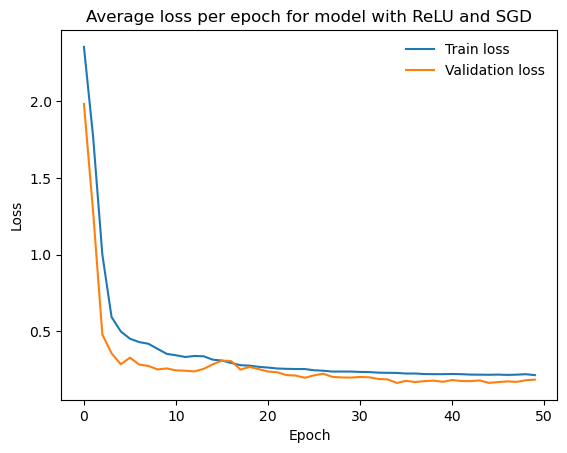

In [24]:
# Plot training and validation loss against epochs

plt.title("Average loss per epoch for model with ReLU and SGD")
plt.plot(range(0, epochs), model.loss_history, label = "Train loss")
plt.plot(range(0, epochs), model.valid_loss_history, label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(frameon = False)
plt.show()

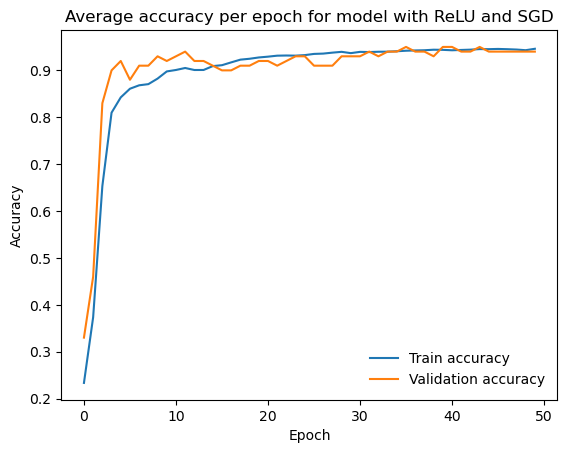

In [25]:
# Plot training and validation accuracy against epochs

plt.title("Average accuracy per epoch for model with ReLU and SGD")
plt.plot(range(0, epochs), model.accuracy_history, label = "Train accuracy")
plt.plot(range(0, epochs), model.valid_accuracy_history, label = "Validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(frameon = False)
plt.show()